In [ ]:
"""
input:
    - main_configs.json
    - state_and_sentiment_counts.parquet
    - date_and_sentiment_counts.parquet
    - fisher_exact_test_results_date.parquet
    - fisher_exact_test_results_state.parquet
output:
    - atv_stachgraph.png
    - sentiment_analysis_fisher_exact_colored_padj_50plus.png
"""

In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from src.scripts.common_figures import Figures

# Loading Data

In [3]:
with open("/src/main_configs.json", 'r') as f:
    main_configs = json.load(f)

probs_path = "/data/processed/CTM/probs"
main_figures_path = "/figures/experimental/main_figures"
dataframes_path = "/data/processed/dataframes"

figures = Figures()

In [5]:
state_and_sentiment_counts = pd.read_parquet(f"{dataframes_path}/state_and_sentiment_counts.parquet")
date_and_sentiment_counts = pd.read_parquet(f"{dataframes_path}/date_and_sentiment_counts.parquet")
fisher_exact_test_results_date = pd.read_parquet(f"{dataframes_path}/fisher_exact_test_results_date.parquet")
fisher_exact_test_results_state = pd.read_parquet(f"{dataframes_path}/fisher_exact_test_results_state.parquet")

In [6]:
date_and_sentiment_counts.groupby('label').agg('sum').reset_index()

<ipython-input-6-318ca4b12138>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  date_and_sentiment_counts.groupby('label').agg('sum').reset_index()


,label,counts
0,Anti,9760275
1,Pro,19267156
2,Rest,2731770


In [7]:
state_and_sentiment_counts = state_and_sentiment_counts.pivot_table(values='counts', index='state', columns='label').reset_index().fillna(0)
state_and_sentiment_counts.iloc[:, 1:] = state_and_sentiment_counts.iloc[:, 1:].astype(int)

date_and_sentiment_counts = date_and_sentiment_counts.pivot_table(values='counts', index='created_at', columns='label').reset_index().fillna(0)
date_and_sentiment_counts.iloc[:, 1:] = date_and_sentiment_counts.iloc[:, 1:].astype(int)

<ipython-input-7-bfb42e2ebda1>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  state_and_sentiment_counts.iloc[:, 1:] = state_and_sentiment_counts.iloc[:, 1:].astype(int)


# Figures

### Sentiment Timeline

In [9]:
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

grid = np.linspace(2020, 2022, num=date_and_sentiment_counts.shape[0])

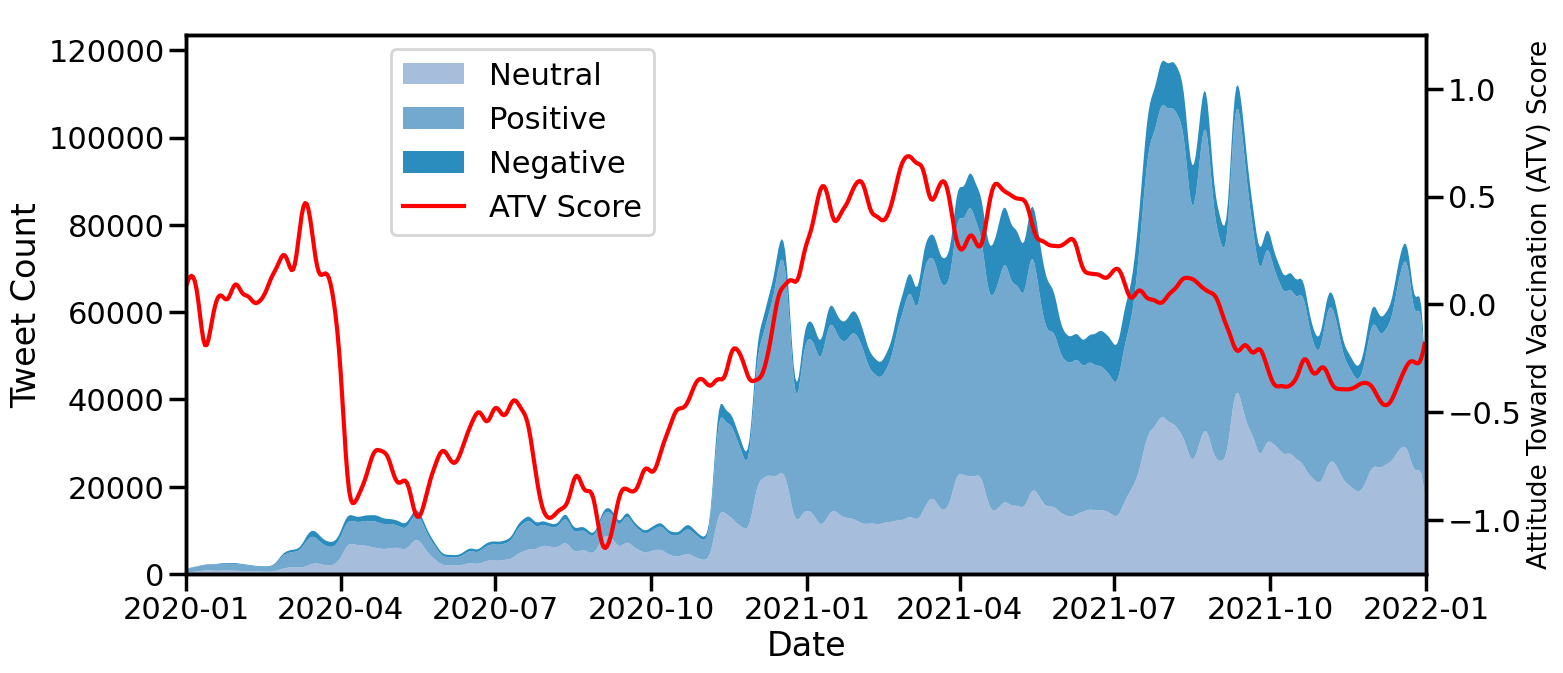

In [11]:
COLORS = ["#A6BDDB", "#74A9CF", "#2B8CBE", "#045A8D"]
sns.set_context("poster", font_scale=1)
fig, ax = plt.subplots(figsize=(16, 8))
y_smoothed = [gaussian_smooth(grid, y_, grid, 0.008) for y_ in date_and_sentiment_counts.iloc[:, 1:].values.T]
y_smoothed2 = gaussian_smooth(grid, fisher_exact_test_results_date['odd_ratios'].values, grid, 0.008)
ax.stackplot(pd.to_datetime(date_and_sentiment_counts.iloc[:, 0]), y_smoothed, colors=COLORS, labels=['Rest', 'Pro', 'Anti'])
ax.set_xlabel('Date')
ax.set_ylabel('Tweet Count')
ax.set_xlim([pd.to_datetime('2020-01-01'), pd.to_datetime('2022-01-01')])
ax2 = ax.twinx()

ax2.plot(pd.to_datetime(date_and_sentiment_counts.iloc[:, 0]), y_smoothed2, label='Pos/Neg Index', c='r', linewidth=3)
ax2.set_ylim([-1.25, 1.25])
ax2.set_ylabel('Attitude Toward Vaccination (ATV) Score', fontdict=dict(size=19))
fig.legend(['Neutral', 'Positive', 'Negative', 'ATV Score'], loc=(0.25, 0.65))
ax.margins(x=0)
plt.savefig(f'{main_figures_path}/atv_stachgraph.png', dpi=300, bbox_inches='tight')

### Volcano Plot with Fisher Exact

In [10]:
fisher_exact_test_results_state = fisher_exact_test_results_state[fisher_exact_test_results_state['state'].isin(main_configs['us_51_state'])]

In [11]:
def y_axis_format(x, pos):
    """The two args are the value and tick position"""
    if x == 50.0:
        return "50.0+"
    else:
        return x
        
y_axis_format = FuncFormatter(y_axis_format)

def limit_values(x):
    if x < 50.0:
        return x
    else:
        return 50.0

limit_values = np.vectorize(limit_values)

fisher_exact_test_results_state['padj'] = limit_values(fisher_exact_test_results_state['padj'].values)

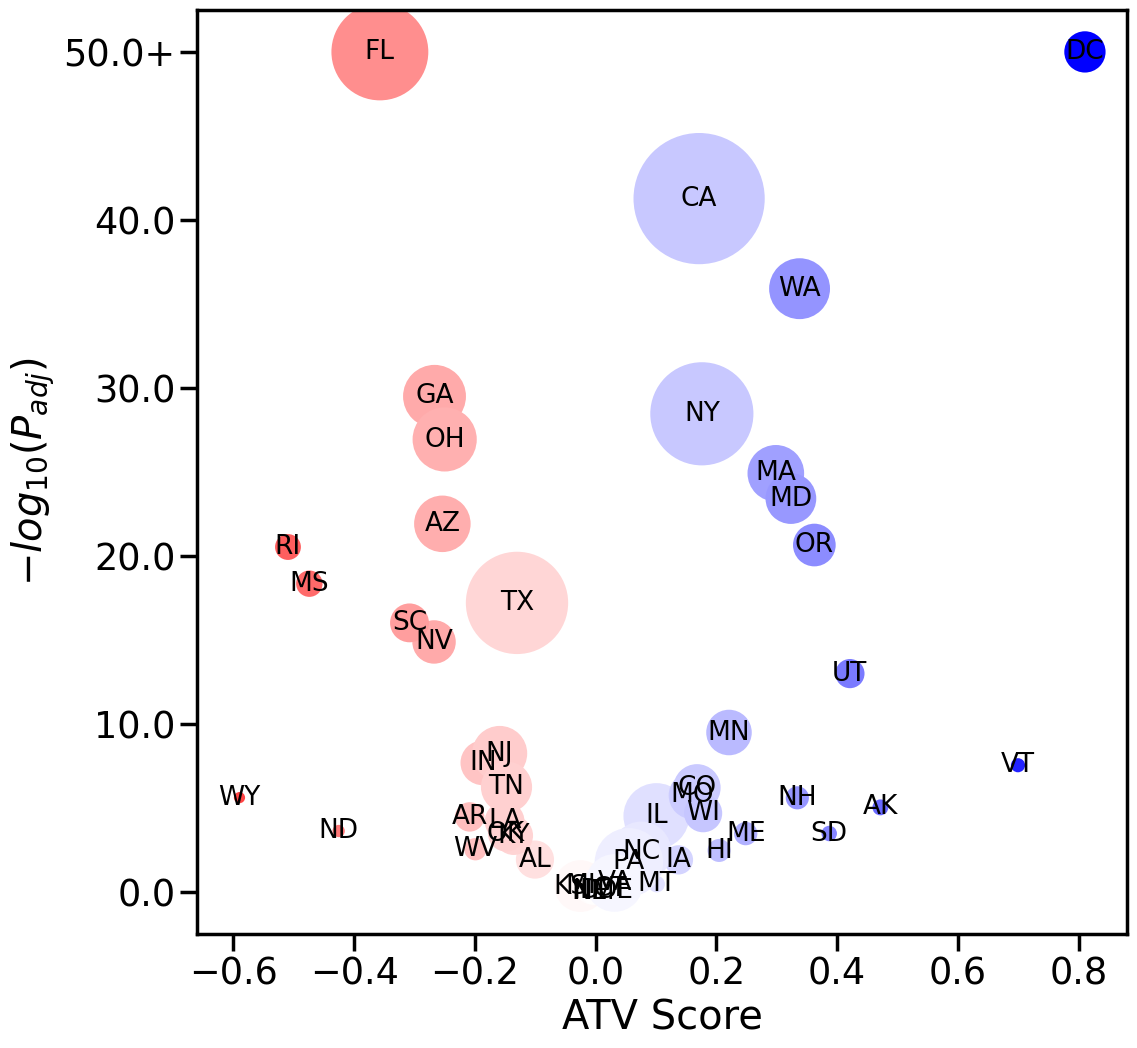

In [12]:
save = f"{main_figures_path}/sentiment_analysis_fisher_exact_colored_padj_50plus.png"
colors = ['red','white', 'blue']

sns.set_context("poster", font_scale=1.1)
figures.volcano_plot(fisher_exact_test_results_state, 'odd_ratios', 'padj',
                     colors, y_axis_formatter=y_axis_format,
                     point_size_multiplexer=0.2, figsize=(12, 9), save=save, paper_figure=None)